# Stand-alone tools
Along with the core functionality of the [Lines](../api/sfrmaker.lines.rst#sfrmaker.lines.Lines) and [SFRData](../api/sfrmaker.sfrdata.rst#sfrmaker.sfrdata.SFRData) classes, SFRmaker also has stand-alone tools that may be useful in work related to the SFR package or other model components.

In [1]:
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import sfrmaker
from sfrmaker.routing import find_path, get_upsegs, make_graph, make_reverse_graph

**Set up the Tyler Forks tests model SFR package**  
See [Using SFRmaker in a scripting context](SFRmaker_demo.ipynb) for more details

In [2]:
%%capture
lns = sfrmaker.Lines.from_nhdplus_v2(NHDPlus_paths='../tylerforks/NHDPlus/',
                            bbox_filter='../tylerforks/grid.shp')
m = flopy.modflow.Modflow.load('tf.nam', model_ws='../tylerforks/tylerforks')
mg = flopy.discretization.StructuredGrid(delr=m.dis.delr.array * .3048,  # cell spacing along a row
                                         delc=m.dis.delc.array * .3048,  # cell spacing along a column
                                         xoff=682688, yoff=5139052,  # lower left corner of model grid
                                         angrot=0,  # grid is unrotated
                                         # projected coordinate system of model (UTM NAD27 zone 15 North)
                                         crs=26715
                                         )
sfr = lns.to_sfr(grid=mg, model=m, model_length_units='feet')

## Methods for working with the SFR routing network, or any other directed acyclic graph (DAG)

* the `sfrmaker.routing.find_path` function to trace a routing path from a given reach or segment to the outlet (or for example in the context of GSFLOW, a cascade path from an HRU to an outlet)

* the `sfrmaker.routing.get_upsegs` method to get a list of all segments or reaches upstream of a point within the SFR routing network


### Create a routing dictionary
* from vectors of to/from nodes, which in this case are the segments
* if the `one_to_many=True` (the default), a set of one or more downstream connections is returned for each node
* if `one_to_many=False`, a single integer representing the downstream connection is returned
* SFRmaker's use of dictionaries to work with DAGs was inspired by [this essay](https://www.python.org/doc/essays/graphs/)

In [3]:
routing = make_graph(sfr.segment_data['nseg'], sfr.segment_data['outseg'])
routing[1]

{4}

In [4]:
routing = make_graph(sfr.segment_data['nseg'], sfr.segment_data['outseg'], one_to_many=False)
routing[1]

4

**The routing dictionary produced by ``make_graph`` can also be reversed:**

In [5]:
routing_r = make_reverse_graph(routing)
routing_r[4]

{1, 2}

### Finding a path through the routing network
The returned path includes all nodes between the starting point (in this case 1) and the outlet (0)

In [6]:
path = find_path(routing, 1)
path

[1, 4, 6, 10, 14, 26, 42, 0]

#### Plotting an elevation profile along a path
This can be useful, for example, when an elevation profile along a stream is desired, or if one wants to map the SFR reach that each HRU ultimately discharges to in a GSFLOW model.

Text(0.5, 0, 'Distance in River miles')

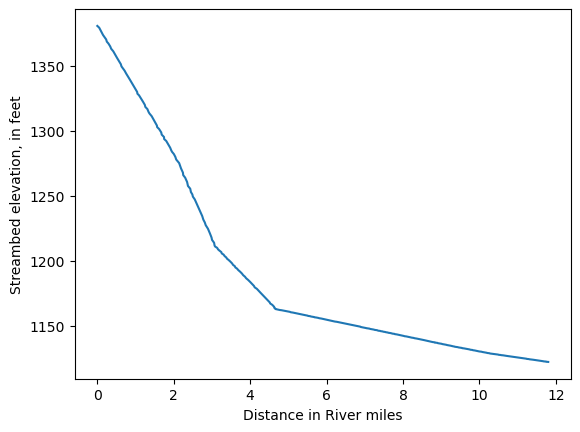

In [7]:
reach_data = pd.DataFrame(m.sfr.reach_data)
reach_data.index = reach_data['reachID']

reach_routing = make_graph(reach_data['reachID'], reach_data['outreach'], one_to_many=False)
path = find_path(reach_routing, 10)

# leave off the outlet segment (0; which doesn't exist) when getting the elevations
path_reach_data = reach_data.loc[path[:-1]]
elevations = path_reach_data['strtop']
distances_mi = np.cumsum(path_reach_data['rchlen'])/5280  # distance along path in miles

plt.plot(distances_mi, elevations)
plt.ylabel('Streambed elevation, in feet')
plt.xlabel('Distance in River miles')

### Getting the upstream contributing segments

The ``get_upsegs`` method takes a reverse routing dictionary (one-to-many) and returns a set of all of the nodes that are upstream of that point. This function is integral to the [streambed elevation smoothing](Streambed_elevation_demo.ipynb) in SFRmaker, and can also be used to aggregate flow components (for example, net groundwater inflow) at a point on the stream network.

In [8]:
get_upsegs(routing_r, 42)

{1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 25, 26}